In [1]:
# import numpy, pandas, sklearn for k-means and pca


import numpy as np
import pandas as pd
import sklearn
import pickle
import matplotlib.pyplot as plt
import umap
import cv2

import keras
import collections

from scipy import ndimage
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
#from sklearn.datasets import load_digits

Using TensorFlow backend.


In [2]:
# import the data from pickle
src = "./data/LSWMD.pkl"
data=pd.read_pickle(src)


# clean the label data as I would be using it for getting a subset
def clean(x):
    if(len(x) == 0):
        return ""
    else:
        return x[0][0]

def replacecolumn(column):
    newcolumn = []
    for entry in column:
        if(len(entry)==0):
            entry = ""
        else:
            entry = entry[0][0]
        newcolumn.append(entry)
    return newcolumn

collabel = replacecolumn(data["trianTestLabel"])
colfailuretype = replacecolumn(data["failureType"])

data["trianTestLabel"] = collabel
data["failureType"] = colfailuretype

# clean unlabeled data
print(data.shape)
data = data[data["failureType"] != ""]
print(data.shape)

(811457, 6)
(172950, 6)


In [28]:
# use the training data as using the whole data set is costly and results in kernel crash.
subdata = data[data['trianTestLabel'] == "Training"] #data cleaning of [["Training"]]-> "Training" needed

#check only defective ones as the defects are in one cluster
#subdata = subdata[data['failureType'] != "none"] #data cleaning of [["Training"]]-> "Training" needed

# fetch the wafer map and failure type
waferdata = subdata["waferMap"]
labelwaferdata = subdata["failureType"]

lb_make = LabelEncoder()
labelwaferdata = lb_make.fit_transform(labelwaferdata)
print(labelwaferdata[0])

# the idea is to have all the circular defects be close to the normal by making any defect at the edge to be rotated to be at the bottom
def rotationmax(wafer):
    rotationlist = []
    rotangle = 60 # having a degree of not 90 results in more empty space which can be resolved with 
    steps = 360//rotangle
    for i in range(steps):
        rotated = ndimage.rotate(wafer, rotangle*i, reshape=False)
        rotationlist.append(rotated)
    
    
    intensitylist = []
    for image in rotationlist:
        #3*(len(a)//4):len(a),:
        intensitysum = sum(sum(image[1*(size[1]//2):size[1],:]))
        intensitylist.append(intensitysum)
    
    idx = np.argmax(intensitylist)
    
    #print(len(rotationlist),idx,steps,intensitylist)

    newwafer = rotationlist[idx]
    
    return newwafer
    
# resize the wafer maps to be uniform

size = (51,51)
thresh = 1.5

newwaferdata = []
for idx,wafer in enumerate(waferdata):
    wafer = cv2.medianBlur(wafer, 5)
    wafer = cv2.medianBlur(wafer, 3)
    wafer = cv2.resize(wafer, dsize=size, interpolation=cv2.INTER_CUBIC)

    #wafer = cv2.medianBlur(wafer, 3)
    #wafer = rotationmax(wafer)
    wafer = cv2.threshold(wafer, thresh, 255, cv2.THRESH_BINARY)[1]    
    #print(wafer.shape)
    #wafer = np.array(wafer).reshape(size[0]*size[1])
    newwaferdata.append(wafer)

newwaferdata = np.array(newwaferdata)
print(newwaferdata.shape,newwaferdata[0].shape)
   
# rotations need to happen to every image as the label data isn't known.

8
(54355, 51, 51) (51, 51)


In [29]:
# the difference here is that instead of just having a flat vector, try using an autoencoder
from keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense,Input, Flatten, Reshape, LeakyReLU as LR, Activation,Dropout

length = newwaferdata.shape[0]


flatnewwaferdata = newwaferdata.reshape((length,size[0]*size[1]))
inputshape = flatnewwaferdata[0].shape
print(inputshape)

encoding_dim = 64
input_img = keras.Input(shape=inputshape)
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(inputshape[0], activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)


encoder = Sequential([
    Flatten(input_shape = newwaferdata[0].shape),
    Dense(1024),
    LR(),
    Dropout(0.5),
    Dense(512),
    LR(),
    Dropout(0.5),
    Dense(256),
    LR(),
    Dropout(0.5),
    Dense(128),
    LR(),
    Dropout(0.5),
    Dense(encoding_dim),
    LR()
])

decoder = Sequential([
    Dense(128,input_shape = (encoding_dim,)),
    LR(),
    Dropout(0.5),
    Dense(256),
    LR(),
    Dropout(0.5),
    Dense(512),
    LR(),
    Dropout(0.5),
    Dense(1024),
    LR(),
    Dropout(0.5),
    Dense(inputshape[0]),
    Activation("sigmoid"),
    Reshape(newwaferdata[0].shape)
])

img = Input(shape = newwaferdata[0].shape)
latent_vector =encoder(img)
output = decoder(latent_vector)

autoencoder = Model(inputs = img, outputs = output)
autoencoder.compile("nadam",loss = "binary_crossentropy")

# # encoder and decoder
# encoder = keras.Model(input_img, encoded)

# encoded_input = keras.Input(shape=(encoding_dim,))
# # Retrieve the last layer of the autoencoder model
# decoder_layer = autoencoder.layers[-1]
# # Create the decoder model
# decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

# compile
#autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

print(autoencoder)

(2601,)


In [30]:
EPOCHS = 10
history = autoencoder.fit(newwaferdata, newwaferdata,
                epochs=EPOCHS,
                batch_size=128,
                shuffle=True,
                validation_data=(newwaferdata, newwaferdata))


Train on 54355 samples, validate on 54355 samples
Epoch 1/10
54355/54355 [==============================] - 68s 1ms/sample - loss: -8.0715 - val_loss: -6.3161
Epoch 2/10
54355/54355 [==============================] - 60s 1ms/sample - loss: -0.5173 - val_loss: 6.4532
Epoch 3/10
54355/54355 [==============================] - 62s 1ms/sample - loss: 8.3725 - val_loss: 10.3839
Epoch 4/10
54355/54355 [==============================] - 67s 1ms/sample - loss: 10.6681 - val_loss: 11.1665
Epoch 5/10
54355/54355 [==============================] - 65s 1ms/sample - loss: 11.3803 - val_loss: 11.7674
Epoch 6/10
54355/54355 [==============================] - 67s 1ms/sample - loss: 12.0625 - val_loss: 12.4246
Epoch 7/10
54355/54355 [==============================] - 65s 1ms/sample - loss: 12.4032 - val_loss: 12.7777
Epoch 8/10
54355/54355 [==============================] - 64s 1ms/sample - loss: 12.9865 - val_loss: 13.5224
Epoch 9/10
54355/54355 [==============================] - 64s 1ms/sample - loss:

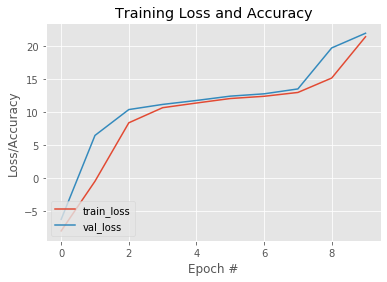

In [31]:
#loss measure
N = np.arange(0, EPOCHS)

plt.style.use("ggplot")

plt.figure()

plt.plot(N, history.history["loss"], label="train_loss")

plt.plot(N, history.history["val_loss"], label="val_loss")

plt.title("Training Loss and Accuracy")

plt.xlabel("Epoch #")

plt.ylabel("Loss/Accuracy")

plt.legend(loc="lower left")

# plt.savefig(plot)

plt.show(block=True)

In [32]:
reducedwaferdata = encoder.predict(newwaferdata)

print(reducedwaferdata,reducedwaferdata.shape)
#print(umap)
model = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42
)
umapdata = model.fit_transform(reducedwaferdata) #, y = labelwaferdata)
umapdata.astype("double")

[[-0.04340648  0.06462518 -0.01414474 ... -0.02808371 -0.01823064
  -0.02069681]
 [-0.04340648  0.06462518 -0.01414474 ... -0.02808371 -0.01823064
  -0.02069681]
 [-0.04340648  0.06462518 -0.01414474 ... -0.02808371 -0.01823064
  -0.02069681]
 ...
 [-0.04340648  0.06462518 -0.01414474 ... -0.02808371 -0.01823064
  -0.02069681]
 [-0.04340648  0.06462518 -0.01414474 ... -0.02808371 -0.01823064
  -0.02069681]
 [-0.04340648  0.06462518 -0.01414474 ... -0.02808371 -0.01823064
  -0.02069681]] (54355, 64)


array([[-1.8969003 ,  4.43935919],
       [-4.35620022,  3.8382659 ],
       [-4.47177696,  4.97366714],
       ...,
       [-3.42093277,  4.56318998],
       [-3.34484553,  3.14747739],
       [-1.54654109,  3.9829905 ]])

['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Random', 'Scratch', 'Near-full', 'none']
Counter({'black': 36730, 'green': 8554, 'red': 3462, 'yellow': 2417, 'blue': 1620, 'cyan': 609, 'purple': 500, 'orange': 409, 'lime': 54})
Counter({'none': 36730, 'Edge-Ring': 8554, 'Center': 3462, 'Edge-Loc': 2417, 'Loc': 1620, 'Random': 609, 'Scratch': 500, 'Donut': 409, 'Near-full': 54})


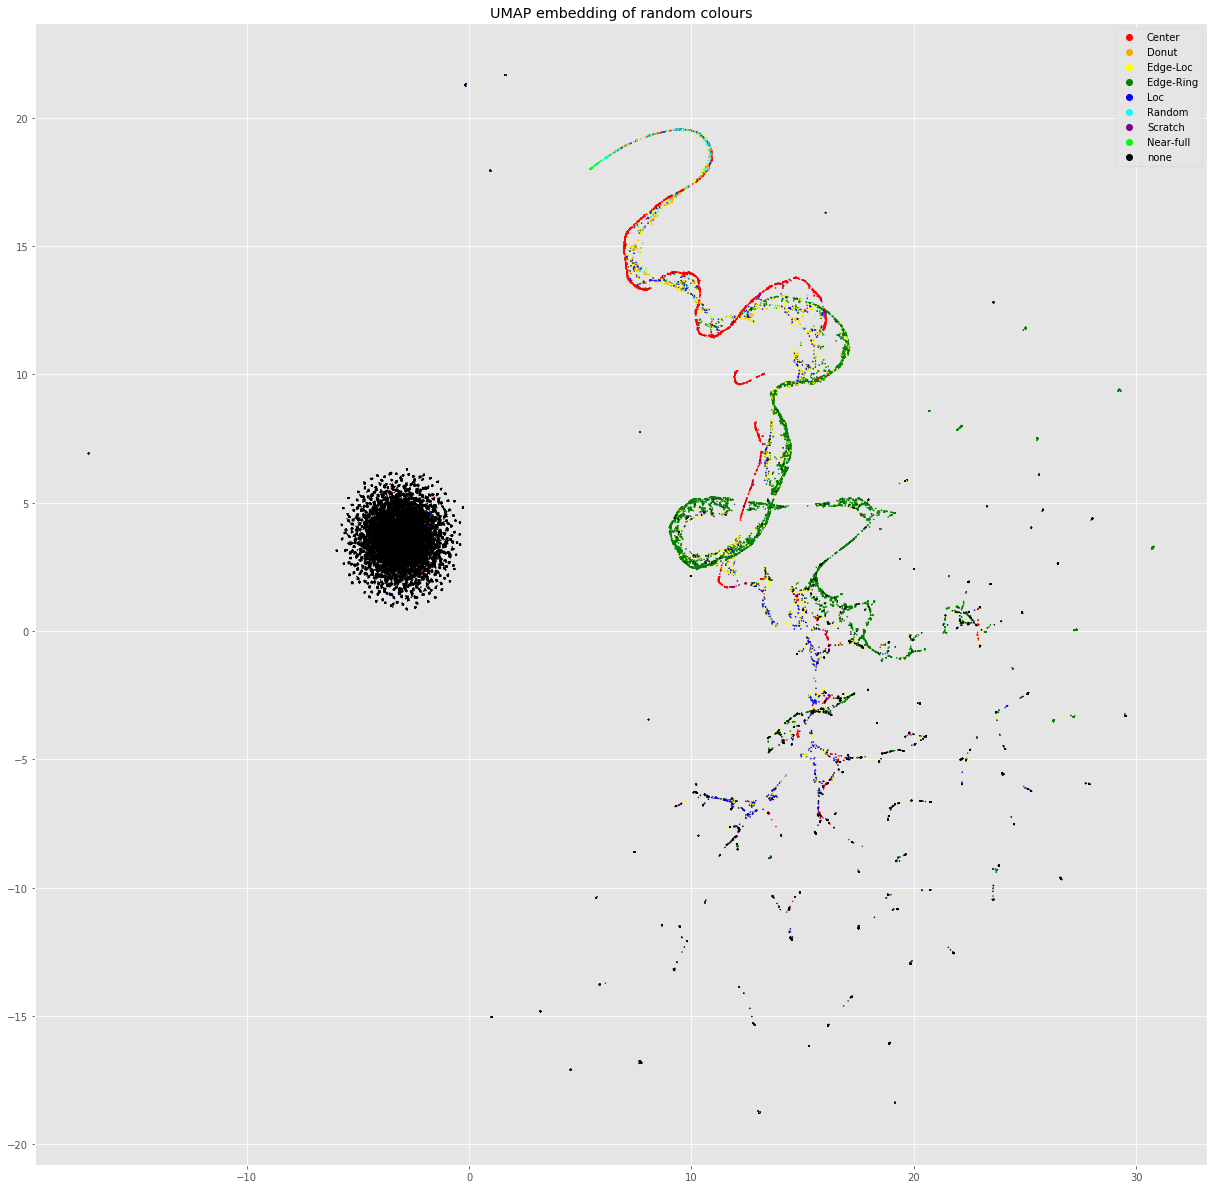

In [33]:
#Center, Donut, Edge-Loc, Edge-Ring, Loc, Random, Scratch, Near-full, none.
import matplotlib.patches as mpatches

classes = ["Center", "Donut", "Edge-Loc", "Edge-Ring", "Loc", "Random", "Scratch", "Near-full","none"]


colormap = {
    "Center"   : "red",
    "Donut"    : "orange",
    "Edge-Loc" : "yellow",
    "Edge-Ring": "green",
    "Loc"      : "blue",
    "Random"   : "cyan",
    "Scratch"  : "purple",
    "Near-full": "lime",
    "none"     : "black"
}

colors = subdata["failureType"].map(colormap)

#classes = list(set(lb_make.inverse_transform(labelwaferdata)))
print(classes)
print(collections.Counter(colors))
print(collections.Counter(subdata["failureType"]))


plt.figure(figsize=(21, 21))
scatter = plt.scatter(umapdata[:,0], umapdata[:,1], c=colors,s=1.1) #,label=str(classes))
plt.title('UMAP embedding of random colours')


markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colormap.values()]
plt.legend(markers, colormap.keys(), numpoints=1)

plt.show()

# it seems to be able to seperate the defect and nondefect groups better
# need to check the numbers

(54355, 2)
1


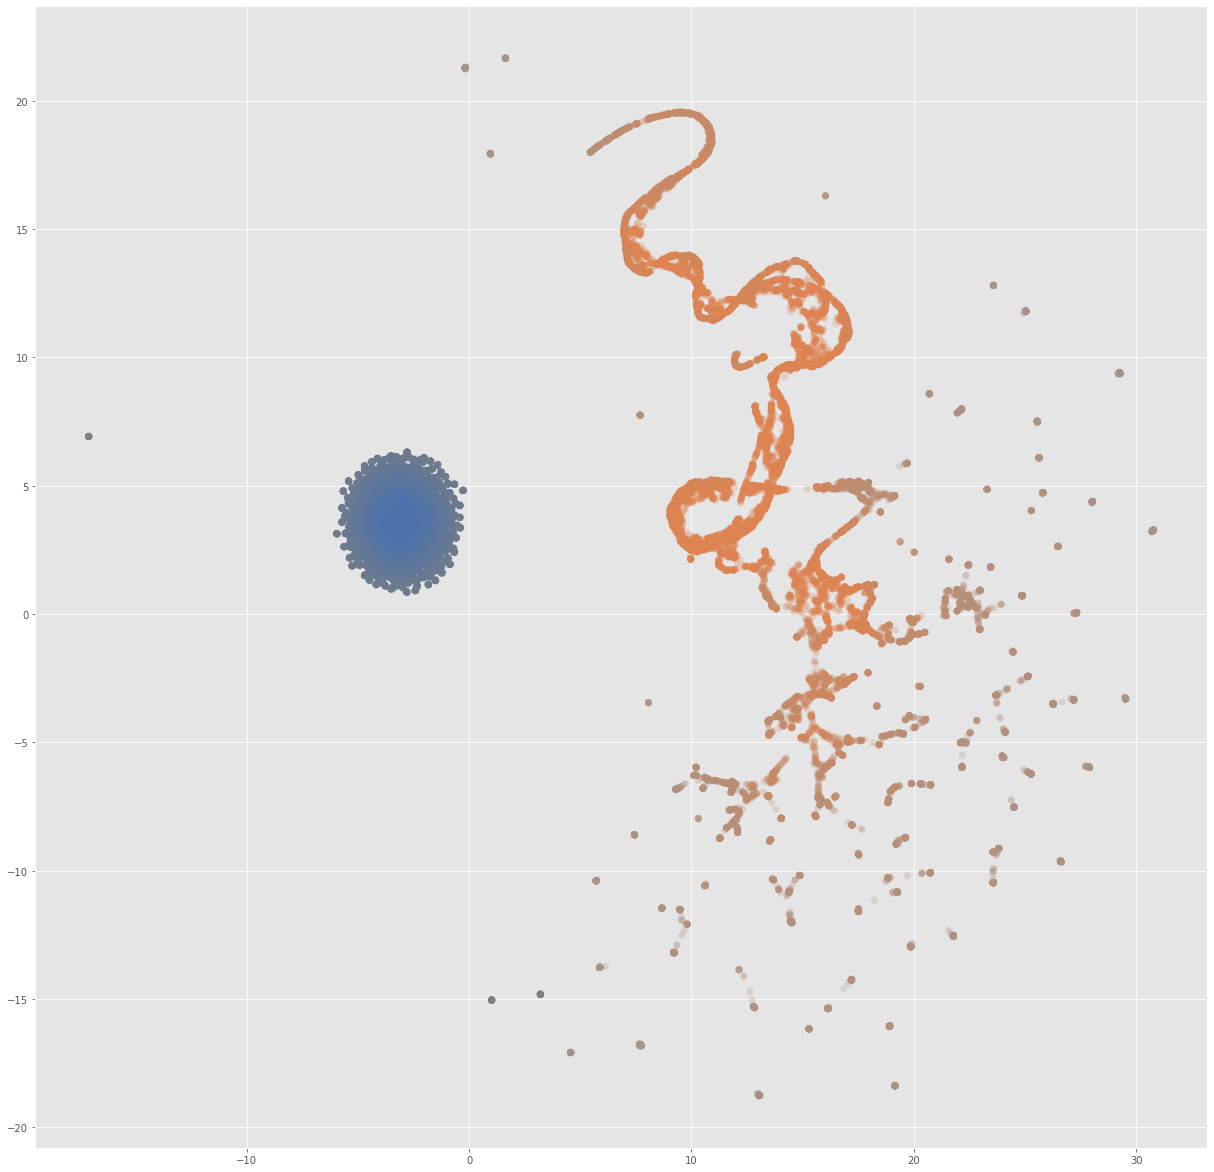

In [34]:
#hdbscan
import hdbscan
import seaborn as sns
print(umapdata.shape)
clustermodel = hdbscan.HDBSCAN(min_cluster_size=1000)
clusterer =clustermodel.fit(umapdata)
print(max(clusterer.labels_))
color_palette = sns.color_palette('deep', max(clusterer.labels_) + 1)
cluster_colors = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in zip(cluster_colors, clusterer.probabilities_)]
plt.figure(figsize=(21, 21))
plt.scatter(umapdata[:,0], umapdata[:,1], s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)

In [35]:
#check which cluster is which
n = 0
test =subdata["failureType"]
label = clusterer.labels_[n]

freq = {}
for label in clusterer.labels_:
    try:
        freq[label] += 1
    except:
        freq[label] = 1
print(freq)

#print(test,label)

{0: 32234, 1: 22025, -1: 96}


In [36]:
# metrics
print(clusterer.labels_)

truelabels = subdata["failureType"]
#collapse 10 types into 2 defect and nondefect

binarylabel = []
for label in clusterer.labels_:
    if(label == 1):
        binarylabel.append("True")
    elif(label == -1):
        binarylabel.append("Outlier")
    else:
        binarylabel.append("False")

binarytruelabel = []
for truelabel in truelabels:
    if(truelabel == "none"):
        binarytruelabel.append("True")
    else:
        binarytruelabel.append("False")
        

rates = [0,0,0,0] #[TP,FP,FN,TN]
outlier = 0
for x,y in zip(binarylabel,binarytruelabel):
    if(x == "True" and y == "True"):
        rates[0] += 1
    if(x == "True" and y == "False"):
        rates[1] += 1
    if(x == "False" and y == "True"):
        rates[2] += 1
    if(x == "False" and y == "False"):
        rates[3] += 1
    if(x == "Outlier"):
        outlier += 1
        
# confusion matrix
print(rates,outlier)
TP = rates[0]
FP = rates[1]
FN = rates[2]
TN = rates[3]
print((TP+TN)/(TP+FP+FN+TN))

[0 0 0 ... 0 0 0]
[5306, 16719, 31339, 895] 96
0.11428518771079452


missing a defect is worse than defecting a good wafer (FP is worse)

#sources
https://learning.oreilly.com/library/view/beginning-anomaly-detection/9781484251775/A483137_1_En_4_Chapter.html (autoencoders)
https://magenta.tensorflow.org/transformer-autoencoder
https://blog.keras.io/building-autoencoders-in-keras.html
https://medium.com/building-deep-autoencoder-with-keras-and-tensorflo/building-deep-autoencoders-with-keras-and-tensorflow-a97a53049e4d
https://towardsdatascience.com/anomaly-detection-for-dummies-15f148e559c1
